In [2]:
import requests

url = "https://www.openml.org//data/download/22102255/dataset"
r = requests.get(url, allow_redirects= True)

In [3]:
with open("dataset.text","wb") as f:
    f.write(r.content)

In [4]:
import pandas as pd

In [5]:
data = []

with open("dataset.text","r") as f:
    for line in f.read().split("\n"):
        if line.startswith("@") or line.startswith("%") or line=="":
            continue
        data.append(line)    

In [6]:
columns =[]

with open("dataset.text","r") as f:
    for line in f.read().split("\n"):
        if line.startswith("@ATTRIBUTE"):
            columns.append(line.split(" ")[1])
            

In [7]:
with open("df.csv","w") as f:
    f.write(",".join(columns))
    f.write("\n")
    f.write("\n".join(data))

In [8]:
df = pd.read_csv("df.csv")
df.columns = columns

In [9]:
df['t_win'] = df.round_winner.astype("category").cat.codes

t_win                           1.000000
ct_armor                        0.336382
ct_helmets                      0.308255
t_helmets                       0.297458
ct_defuse_kits                  0.291557
t_armor                         0.290753
ct_grenade_flashbang            0.253868
ct_players_alive                0.216798
ct_grenade_smokegrenade         0.209975
ct_weapon_awp                   0.198626
t_weapon_ak47                   0.194147
ct_health                       0.190662
bomb_planted                    0.187101
ct_weapon_m4a4                  0.178008
ct_grenade_hegrenade            0.168781
ct_grenade_incendiarygrenade    0.168517
ct_weapon_ak47                  0.166855
t_grenade_flashbang             0.166839
ct_weapon_sg553                 0.163963
t_weapon_sg553                  0.163709
ct_weapon_usps                  0.152893
t_weapon_awp                    0.149878
t_players_alive                 0.142518
t_grenade_smokegrenade          0.140348
t_weapon_usps   

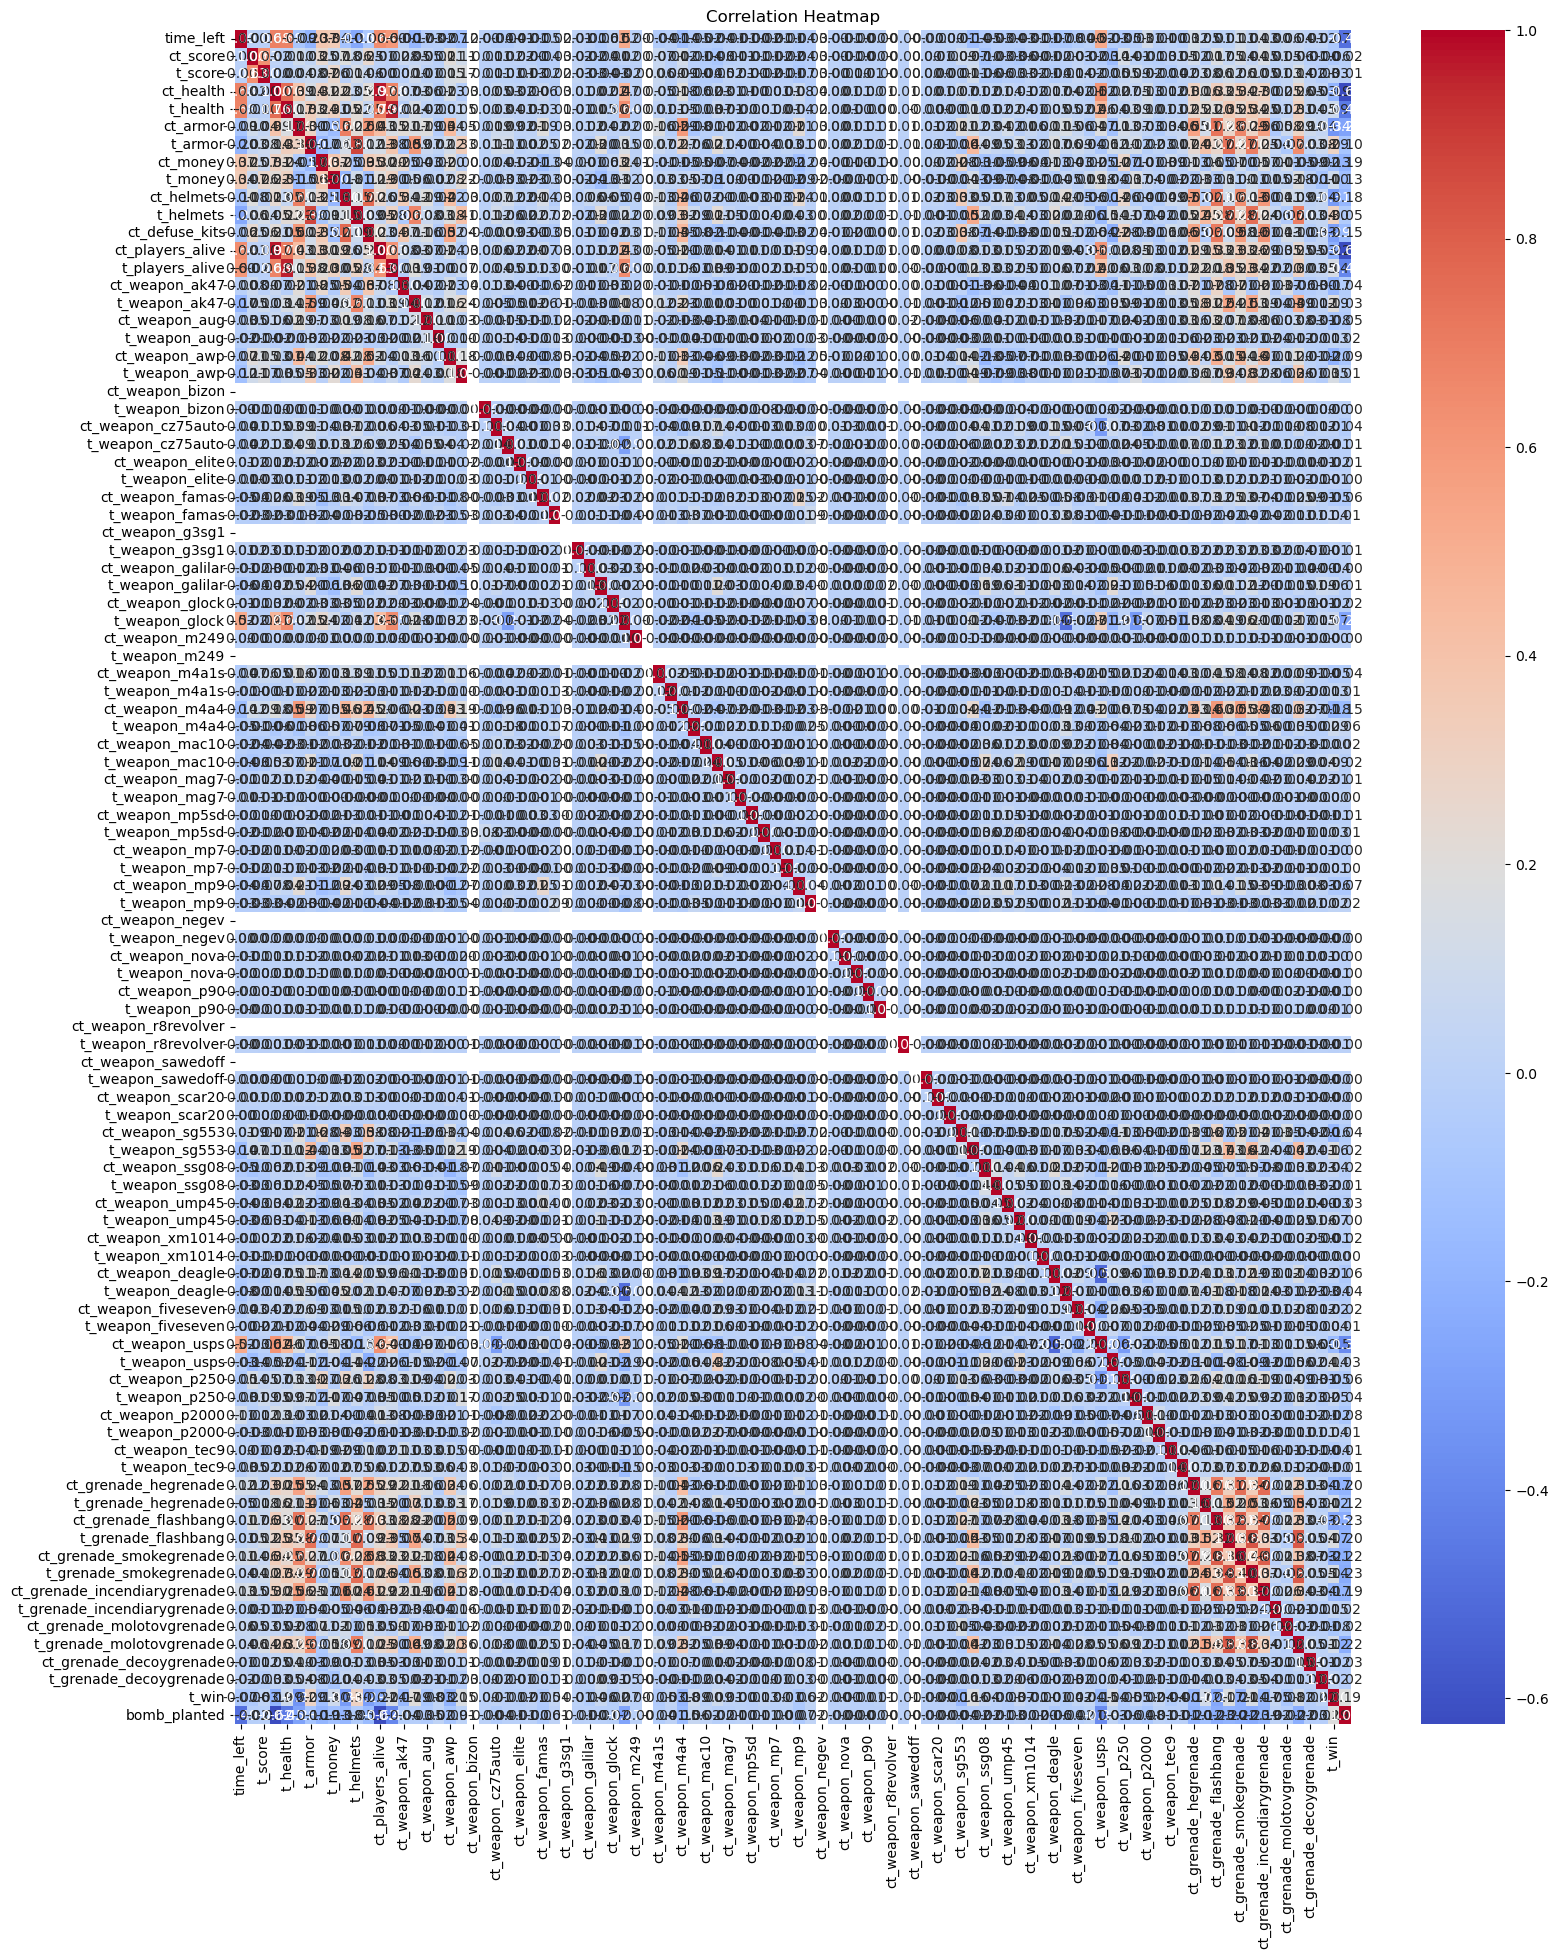

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out non-numeric columns
numeric_columns = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]

# Include the boolean column 'bomb_planted' and the target column 't_win' in the list of numeric columns
numeric_columns.extend(["t_win", "bomb_planted"])

# Convert boolean values to numeric (True -> 1, False -> 0)
df['bomb_planted'] = df['bomb_planted'].astype(int)

# Select only the numeric columns from the DataFrame
numeric_df = df[numeric_columns]

# Calculate correlations
correlations = numeric_df.corr()

# Print absolute correlations sorted in descending order
print(correlations['t_win'].apply(abs).sort_values(ascending=False).iloc[:25])

# Plotting heatmap for visualization
plt.figure(figsize=(18, 22))
sns.heatmap(correlations, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()



In [11]:
selected_columns = []

for col in columns+["t_win"]:
    try:
        if abs(correlations[col]['t_win']) > 0.15:
            selected_columns.append(col)
    except KeyError:
        pass
    
df_selected = df[selected_columns]

<Axes: >

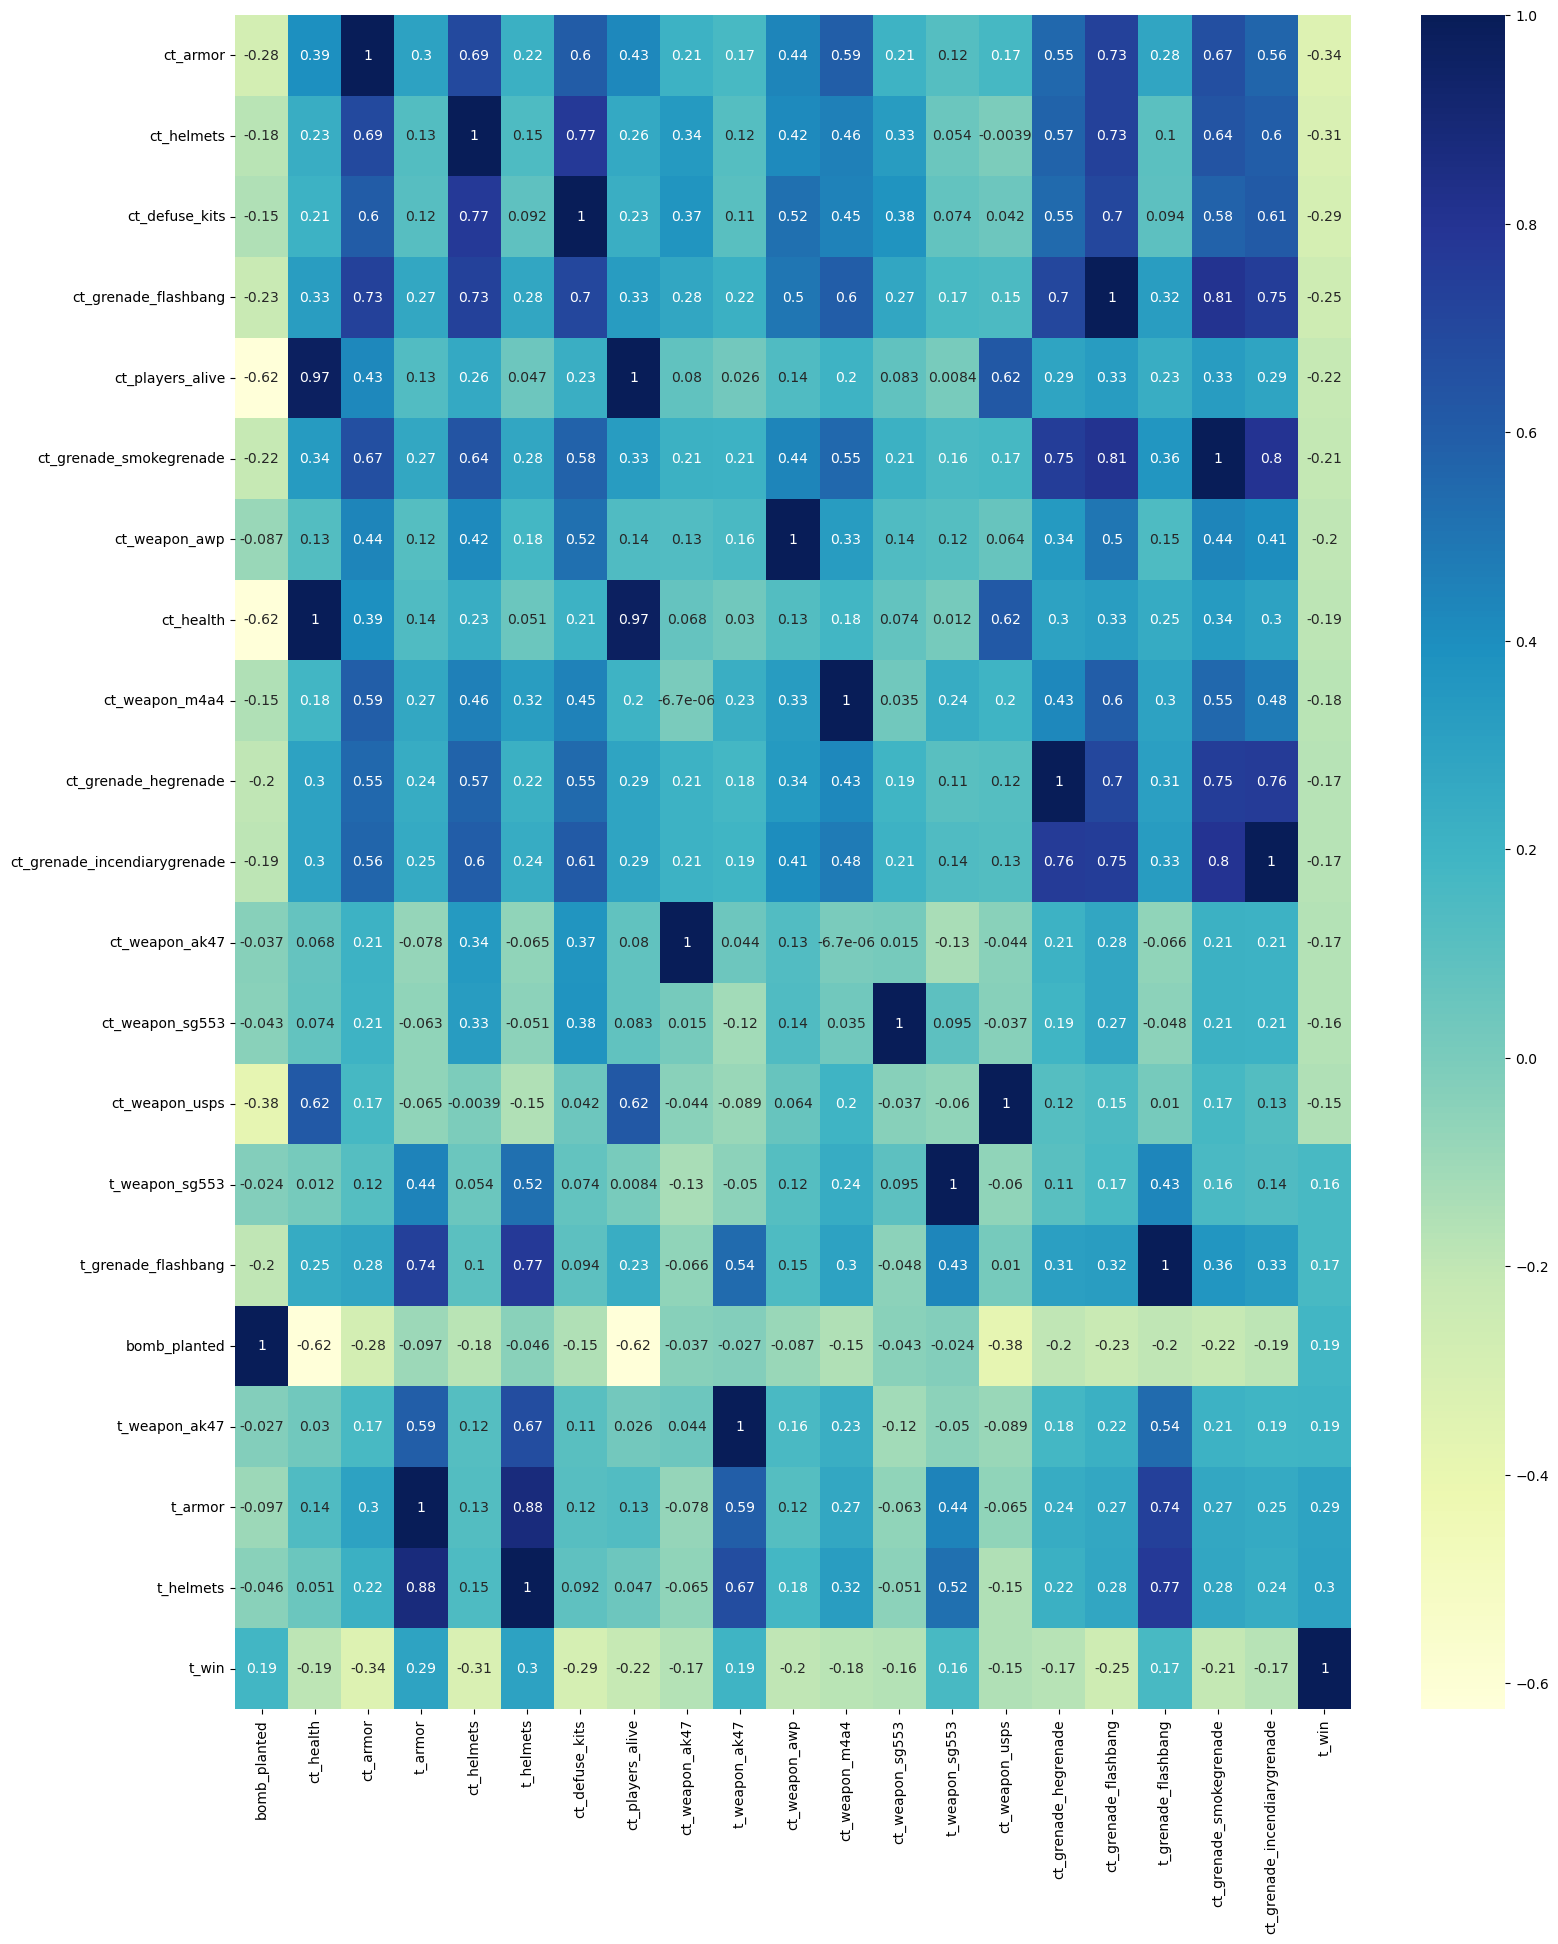

In [12]:
plt.figure(figsize=(18,22))
sns.heatmap(df_selected.corr().sort_values(by="t_win"), annot=True, cmap="YlGnBu")

array([[<Axes: title={'center': 'bomb_planted'}>,
        <Axes: title={'center': 'ct_health'}>,
        <Axes: title={'center': 'ct_armor'}>,
        <Axes: title={'center': 't_armor'}>,
        <Axes: title={'center': 'ct_helmets'}>],
       [<Axes: title={'center': 't_helmets'}>,
        <Axes: title={'center': 'ct_defuse_kits'}>,
        <Axes: title={'center': 'ct_players_alive'}>,
        <Axes: title={'center': 'ct_weapon_ak47'}>,
        <Axes: title={'center': 't_weapon_ak47'}>],
       [<Axes: title={'center': 'ct_weapon_awp'}>,
        <Axes: title={'center': 'ct_weapon_m4a4'}>,
        <Axes: title={'center': 'ct_weapon_sg553'}>,
        <Axes: title={'center': 't_weapon_sg553'}>,
        <Axes: title={'center': 'ct_weapon_usps'}>],
       [<Axes: title={'center': 'ct_grenade_hegrenade'}>,
        <Axes: title={'center': 'ct_grenade_flashbang'}>,
        <Axes: title={'center': 't_grenade_flashbang'}>,
        <Axes: title={'center': 'ct_grenade_smokegrenade'}>,
        <Ax

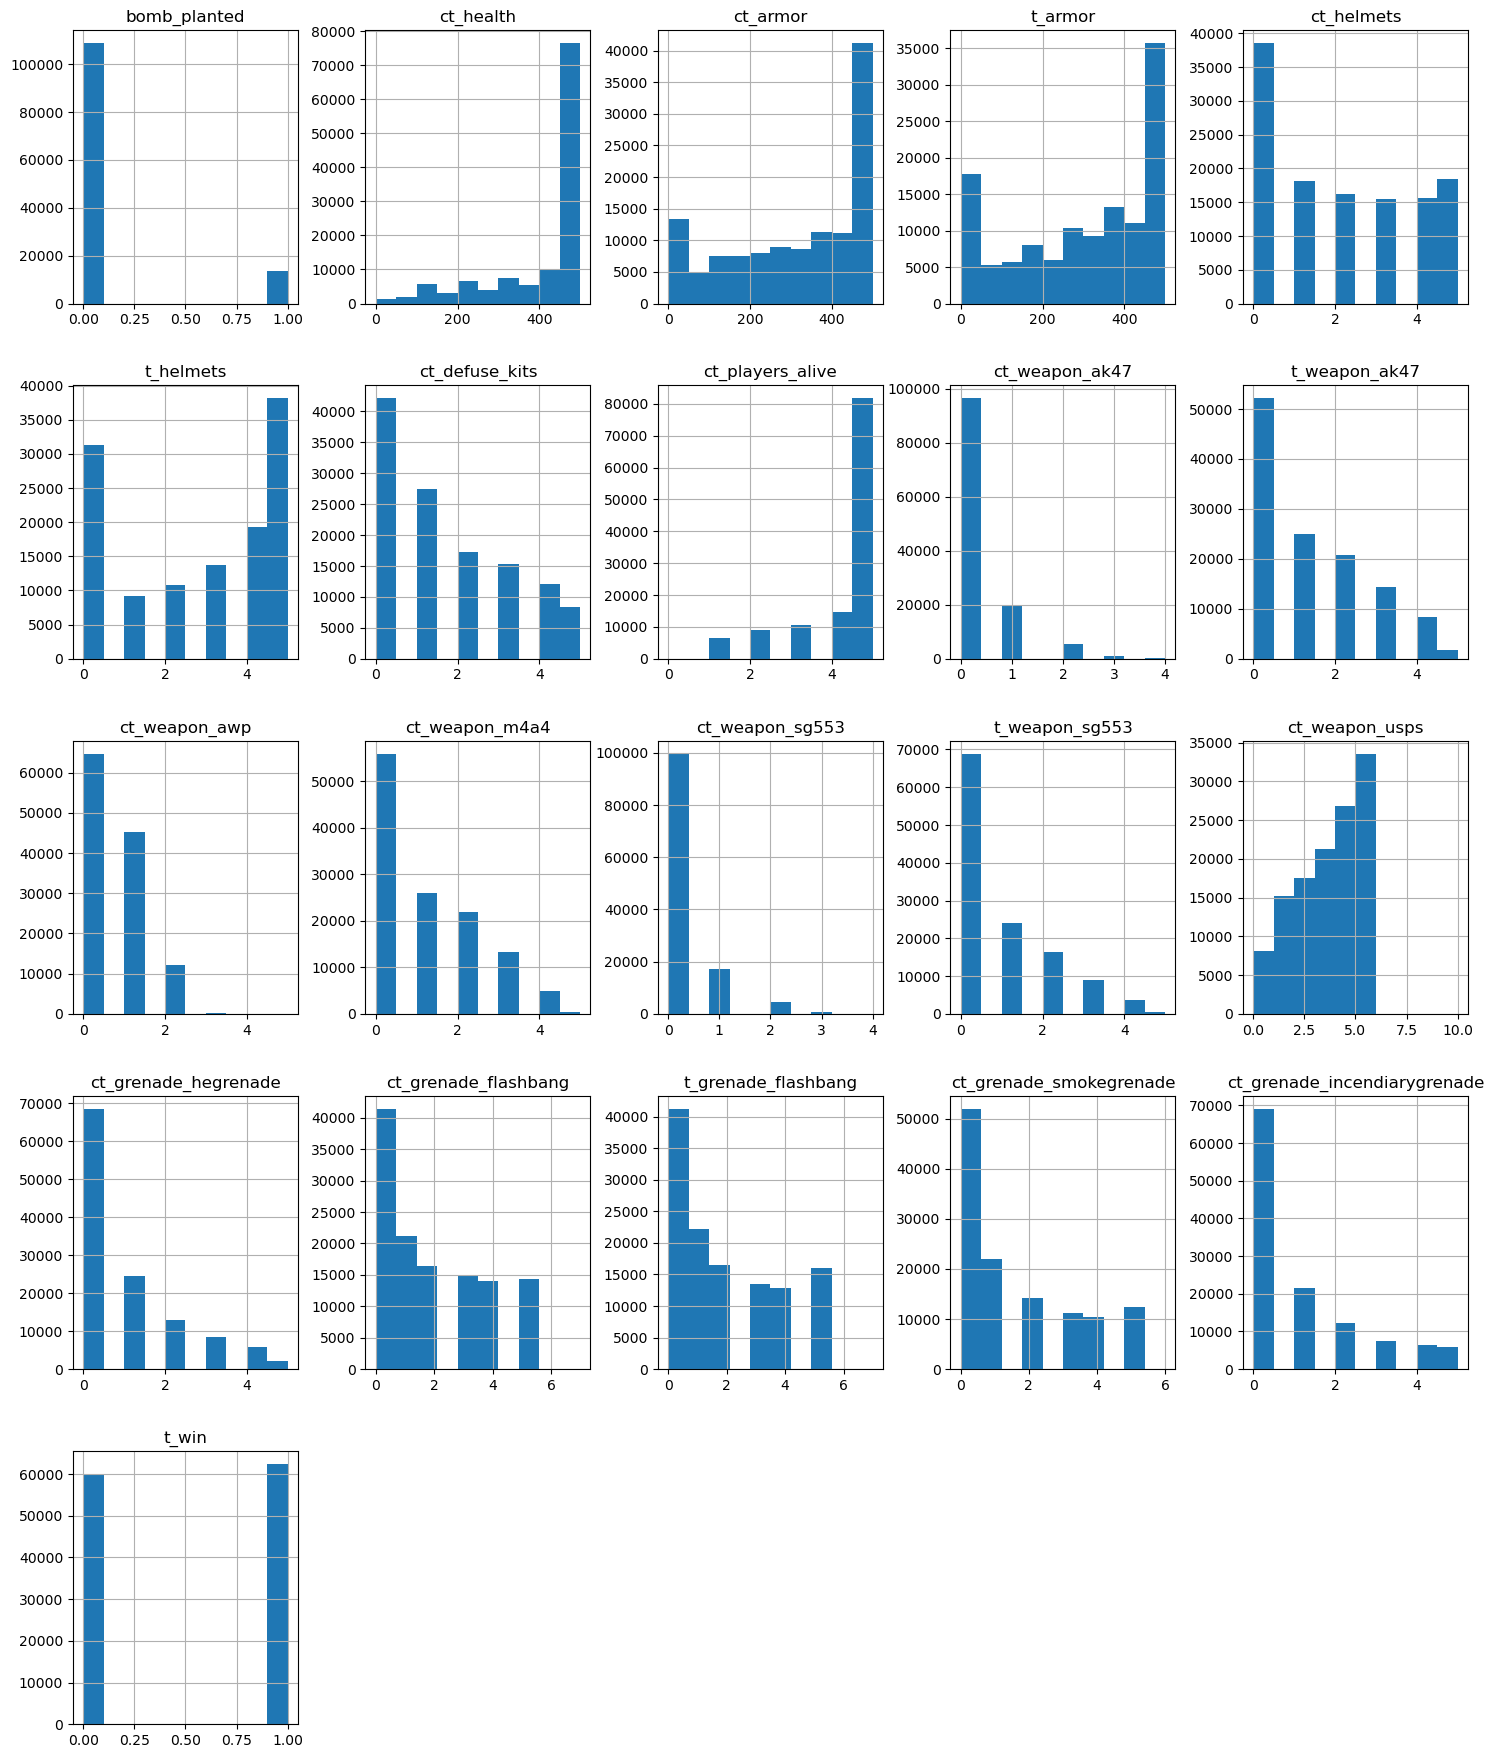

In [13]:
df_selected.hist(figsize=(18,22))

In [14]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   bomb_planted                  122410 non-null  int32  
 1   ct_health                     122410 non-null  float64
 2   ct_armor                      122410 non-null  float64
 3   t_armor                       122410 non-null  float64
 4   ct_helmets                    122410 non-null  float64
 5   t_helmets                     122410 non-null  float64
 6   ct_defuse_kits                122410 non-null  float64
 7   ct_players_alive              122410 non-null  float64
 8   ct_weapon_ak47                122410 non-null  float64
 9   t_weapon_ak47                 122410 non-null  float64
 10  ct_weapon_awp                 122410 non-null  float64
 11  ct_weapon_m4a4                122410 non-null  float64
 12  ct_weapon_sg553               122410 non-nul

In [15]:
from sklearn.model_selection import train_test_split

X, y = df_selected.drop(["t_win"], axis=1), df_selected["t_win"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
len(X_test)

24482

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

scalar = StandardScaler()

X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [18]:
knn.score(X_test_scaled, y_test)

0.7644391798055714

In [19]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_neighbors": list(range(5,17,2)),
    "weights":["uniform","distance"] 
}

knn= KNeighborsClassifier(n_jobs=4)

clf= RandomizedSearchCV(knn, param_grid, n_jobs=4, n_iter=3, verbose=2, cv=3)
clf.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=4), n_iter=3,
                   n_jobs=4,
                   param_distributions={'n_neighbors': [5, 7, 9, 11, 13, 15],
                                        'weights': ['uniform', 'distance']},
                   verbose=2)

In [20]:
knn=clf.best_estimator_

In [21]:
knn.score(X_test_scaled, y_test)

0.7798790948451924

In [22]:
from sklearn.ensemble import RandomForestClassifier

forest= RandomForestClassifier(n_jobs=4)
forest.fit(X_train_scaled, y_train)

RandomForestClassifier(n_jobs=4)

In [23]:
forest.score(X_test_scaled, y_test)

0.8294257005146638

In [24]:
X_train

,bomb_planted,ct_health,ct_armor,t_armor,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_awp,ct_weapon_m4a4,ct_weapon_sg553,t_weapon_sg553,ct_weapon_usps,ct_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,ct_grenade_incendiarygrenade
82957,0,500.0,100.0,94.0,0.0,1.0,1.0,5.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
59177,0,500.0,500.0,364.0,1.0,4.0,1.0,5.0,0.0,2.0,1.0,2.0,1.0,1.0,3.0,2.0,4.0,4.0,1.0,1.0
28521,0,500.0,100.0,482.0,1.0,5.0,1.0,5.0,0.0,3.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0,5.0,0.0,1.0
29302,0,500.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
41272,0,500.0,387.0,0.0,2.0,0.0,0.0,5.0,1.0,0.0,0.0,2.0,0.0,0.0,5.0,2.0,1.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,0,473.0,472.0,100.0,5.0,1.0,5.0,5.0,0.0,0.0,1.0,3.0,0.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0
19267,0,500.0,498.0,300.0,5.0,3.0,4.0,5.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,3.0,2.0,1.0,1.0
85186,0,500.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
79774,0,500.0,498.0,400.0,5.0,2.0,3.0,5.0,1.0,0.0,2.0,1.0,1.0,0.0,4.0,2.0,5.0,4.0,4.0,4.0


In [25]:
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Sequential

# Initialize a Sequential model
model = Sequential()

# Add an Input layer explicitly
model.add(Input(shape=(20,)))  # Assuming the input features shape is (20,)

# Continue adding the rest of the layers
model.add(Dense(200, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(1, activation="sigmoid"))


In [26]:
model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

In [27]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)

X_train_scaled_train, X_valid, y_train_train, y_valid =  train_test_split(X_train_scaled, y_train, test_size=0.15)

model.fit(X_train_scaled_train, y_train_train, epochs=30, callbacks=[early_stopping_cb], validation_data=(X_valid, y_valid))

Epoch 1/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7371 - loss: 0.4910 - val_accuracy: 0.7368 - val_loss: 0.4807
Epoch 2/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7474 - loss: 0.4700 - val_accuracy: 0.7389 - val_loss: 0.4774
Epoch 3/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7511 - loss: 0.4668 - val_accuracy: 0.7425 - val_loss: 0.4688
Epoch 4/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7505 - loss: 0.4634 - val_accuracy: 0.7436 - val_loss: 0.4666
Epoch 5/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7545 - loss: 0.4629 - val_accuracy: 0.7467 - val_loss: 0.4677
Epoch 6/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7559 - loss: 0.4593 - val_accuracy: 0.7471 - val_loss: 0.4662
Epoch 7/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7543 - loss: 0.4572 - val_accuracy: 0.7483 - val_loss: 0.4657
Epoch 8/30
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7593 - loss: 0.4562 - 

In [28]:
model.evaluate(X_test_scaled, y_test)

766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7589 - loss: 0.4642


[0.4672425091266632, 0.7574136257171631]

In [29]:
import numpy as np
from tensorflow import keras

# Assuming 'model' is loaded model

# Generate a random sample scenario with the correct shape
random_scenario = np.random.rand(1, 20)  

# Predict the outcome using the model
prediction = model.predict(random_scenario)
predicted_winner = "Counter-Terrorists" if prediction[0][0] > 0.5 else "Terrorists"

print(f"Predicted winner: {predicted_winner}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Predicted winner: Counter-Terrorists


In [30]:
model.save('my_model.keras')

In [31]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from tensorflow.keras.models import load_model
import random

# path to the saved model
model_path = 'my_model.keras'
model = load_model(model_path)

predict_btn = widgets.Button(description="Predict")
output = widgets.Output()

def on_predict_clicked(b):
    
    
    with output:
        output.clear_output()
        print(f"Making prediction with random map: {random_map_choice}...")
        try:
            prediction = model.predict(input_features)
            predicted_winner = "Counter-Terrorists" if prediction[0][0] > 0.5 else "Terrorists"
            print(f"Predicted winner: {predicted_winner}")
        except Exception as e:
            print(f"An error occurred: {str(e)}")

predict_btn.on_click(on_predict_clicked)




In [32]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from tensorflow.keras.models import load_model
import random

# path to the model
model_path = 'my_model.keras' 
model = load_model(model_path)

# Define the widgets for input features
time_left = widgets.FloatText(description='Time Left:', value=75)
ct_score = widgets.IntText(description='CT Score:', value=5)
t_score = widgets.IntText(description='T Score:', value=3)
bomb_planted = widgets.Dropdown(description='Bomb Planted:', options=[('No', 0), ('Yes', 1)], value=0)
ct_health = widgets.IntText(description='CT Health:', value=500)
t_health = widgets.IntText(description='T Health:', value=500)
ct_armor = widgets.IntText(description='CT Armor:', value=400)
t_armor = widgets.IntText(description='T Armor:', value=300)
ct_money = widgets.IntText(description='CT Money:', value=8000)
t_money = widgets.IntText(description='T Money:', value=7500)
ct_helmets = widgets.IntText(description='CT Helmets:', value=5)
t_helmets = widgets.IntText(description='T Helmets:', value=4)
ct_defuse_kits = widgets.IntText(description='CT Defuse Kits:', value=1)
ct_players_alive = widgets.IntText(description='CT Players Alive:', value=5)
t_players_alive = widgets.IntText(description='T Players Alive:', value=4)
ct_weapons = widgets.IntText(description='CT Weapons:', value=4)
t_weapons = widgets.IntText(description='T Weapons:', value=5)
ct_grenades = widgets.IntText(description='CT Grenades:', value=3)
t_grenades = widgets.IntText(description='T Grenades:', value=2)

predict_btn = widgets.Button(description="Predict")
output = widgets.Output()

def on_predict_clicked(b):
    # Randomly select a map from the available options and encode it
    map_options = ['de_dust2', 'de_inferno', 'de_overpass']
    random_map_choice = random.choice(map_options)
    map_choice_encoded = map_options.index(random_map_choice)  # Simple integer encoding for example
    
    input_features = np.array([[time_left.value, ct_score.value, t_score.value, 
                                map_choice_encoded,  # Use the encoded random map choice
                                bomb_planted.value, ct_health.value, t_health.value,
                                ct_armor.value, t_armor.value, ct_money.value, t_money.value,
                                ct_helmets.value, t_helmets.value, ct_defuse_kits.value,
                                ct_players_alive.value, t_players_alive.value, ct_weapons.value,
                                t_weapons.value, ct_grenades.value, t_grenades.value]], dtype=float)
    
    with output:
        output.clear_output()
        print(f"Making prediction with random map: {random_map_choice}...")
        try:
            prediction = model.predict(input_features)
            predicted_winner = "Counter-Terrorists" if prediction[0][0] > 0.5 else "Terrorists"
            print(f"Predicted winner: {predicted_winner}")
        except Exception as e:
            print(f"An error occurred: {str(e)}")

predict_btn.on_click(on_predict_clicked)

# Layout the widgets, excluding map_choice
input_widgets = [time_left, ct_score, t_score, bomb_planted, ct_health, t_health, 
                 ct_armor, t_armor, ct_money, t_money, ct_helmets, t_helmets, ct_defuse_kits, 
                 ct_players_alive, t_players_alive, ct_weapons, t_weapons, ct_grenades, t_grenades, predict_btn]

display(widgets.VBox(input_widgets), output)


Output()

In [35]:
import anvil.server

anvil.server.connect("server_LKHTDJ7ZYRKF22VA3M2GSBOD-EEGMKJOXDE6M6S4H")

Disconnecting from previous connection first...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER
Reconnecting Anvil Uplink...
